In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
conn = psycopg2.connect(host="",dbname="",user="",password="",port=)

In [3]:
cur = conn.cursor()

### Find the total sales per year.

In [4]:
query = """with sales_byyear as
(
select to_char(orders.order_purchase_timestamp::timestamp, 'yyyy') as year, 
round(sum(payments.payment_value),2) as sales
from orders
join payments 
on payments.order_id = orders.order_id
group by orders.order_purchase_timestamp
)

select year,sum(sales) total_sales from sales_byyear group by year order by year"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Sales"])
df

,Year,Sales
0,2016,59362.34
1,2017,7249746.73
2,2018,8699763.05


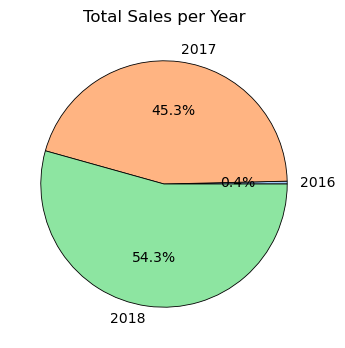

In [5]:
palette_color = sns.color_palette('pastel') 
plt.figure(figsize=(4,4))
plt.pie(df['Sales'], labels=df['Year'], autopct='%1.1f%%', colors=palette_color, wedgeprops = {"edgecolor" : "black", 
                      'linewidth': 0.6, 
                      'antialiased': True})
plt.title('Total Sales per Year')
plt.show()

### Count the number of orders per year.

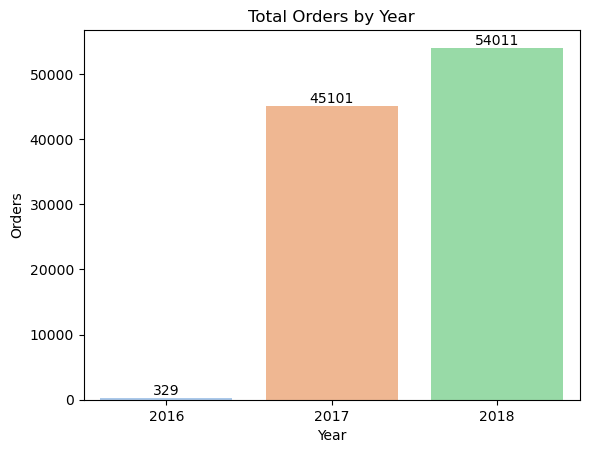

In [6]:
query = """with orders_byyear as
(
select to_char(order_purchase_timestamp::timestamp, 'yyyy') as year, 
count(order_id) as orders
from orders
group by order_purchase_timestamp
)

select year,sum(orders) total_orders from orders_byyear group by year order by year
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Year", "Orders"])
#df

#sns.lineplot(x=df['Year'],y=df['Orders'], estimator=None, sort=False)
ax = sns.barplot(x = df["Year"],y = df["Orders"], data = df, palette='pastel')
plt.xticks(rotation = 0)
ax.bar_label(ax.containers[0])
plt.title("Total Orders by Year")
plt.show()

### Calculate the number of orders per month in 2018 has the highest of sales.

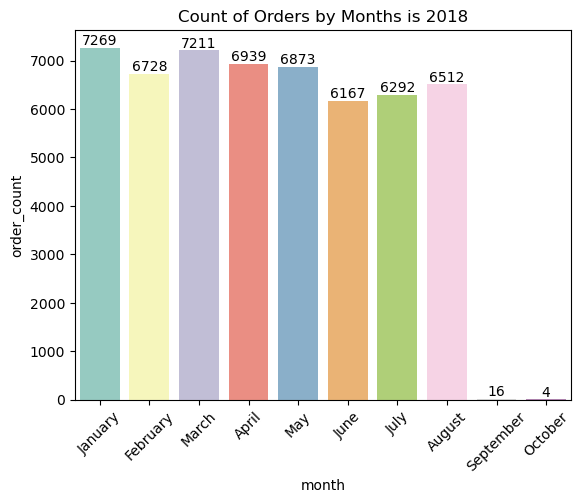

In [7]:
query = """select EXTRACT(MONTH FROM order_purchase_timestamp::timestamp) months,count(distinct order_id) order_count
from orders where EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
df['months'] = df['months'].map({1:"January",2:"February",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"})

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, palette='Set3')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")
plt.xlabel("month")
plt.show()

###  Calculate the month-over-month growth rate of total sales.

In [8]:
query = """with sales_permth as
(select to_date(to_char(orders.order_purchase_timestamp, 'YYYY-MM'),'YYYY-MM') as months,
round(sum(payments.payment_value),2) as payment, count(distinct orders.order_id) count_orders 
from orders 
join payments on orders.order_id = payments.order_id
group by months)

select months,payment,round(cast(((payment - lag(payment, 1) over(order by months))/
lag(payment, 1) over(order by months)) as numeric),2) * 100 as MoMgrowth, sum(count_orders) as Orders 
from sales_permth group by months,payment
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['Month','Sales','MoM%growth','Orders'])
#df['Month'] = df['Month'].map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"June",7:"July",8:"Aug",9:"Sept",10:"Oct",11:"Nov",12:"Dec"})
df = df.set_index('Month')
df

,Sales,MoM%growth,Orders
Month,,,
2016-09-01,252.24,None,3
2016-10-01,59090.48,23326.00,324
2016-12-01,19.62,-100.00,1
2017-01-01,138488.04,705751.00,800
2017-02-01,291908.01,111.00,1780
2017-03-01,449863.60,54.00,2682
2017-04-01,417788.03,-7.00,2404
2017-05-01,592918.82,42.00,3700
2017-06-01,511276.38,-14.00,3245


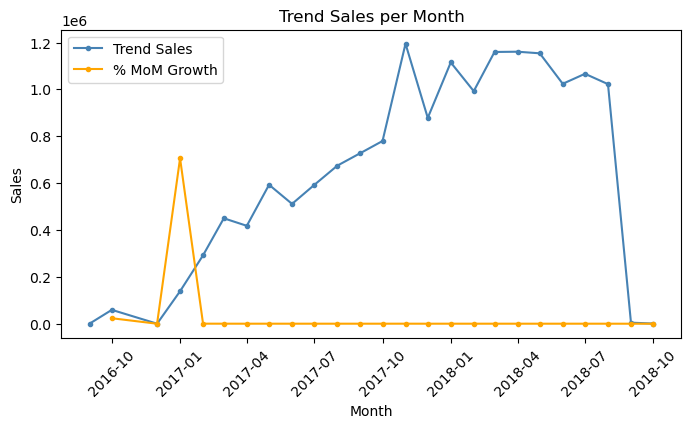

In [9]:
#plt.style.use("fivethirtyeight")
plt.figure(figsize=(8,4))
plt.plot(df['Sales'], marker='.', label='Trend Sales', color='steelblue')
plt.plot(df['MoM%growth'], marker='.', label='% MoM Growth', color='orange')
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Trend Sales per Month")
plt.legend(loc="upper left")
plt.show()

### Calculate the year-over-year growth rate of total sales.

In [10]:
query = """with a as(select EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders 
join payments on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year", "YoY % growth"])
df

,Year,YoY % growth
0,2016,None
1,2017,12112.7037613409444400
2,2018,20.00092381158258752000


### Top 5 of category products which have the highest percentage contributes of sales.

In [11]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales_percentage desc
limit 5
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales", "% Contributes of sales"])
df

,Category,Sales,% Contributes of sales
0,BED TABLE BATH,1712553.67,10.70
1,HEALTH BEAUTY,1657373.12,10.35
2,COMPUTER ACCESSORIES,1585330.45,9.90
3,FURNITURE DECORATION,1430176.39,8.93
4,WATCHES PRESENT,1429216.68,8.93


### Find top 3 product cotegory which contribute numerous orders per year.

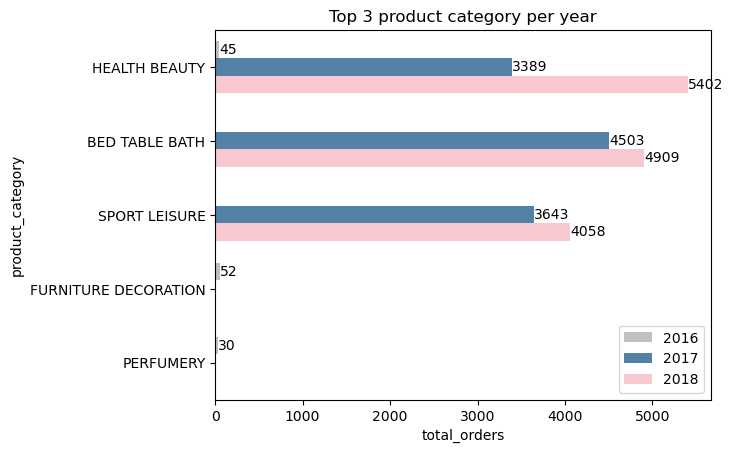

In [12]:
query = """with prod_peryear as
(
select EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) years, upper(p.product_category) as product_category,
count(distinct(i.order_id)) as orders
from order_items i
join products p on p.product_id=i.product_id
join orders o on o.order_id=i.order_id
group by p.product_category, o.order_purchase_timestamp
),

total_prod as
(
select py.years, py.product_category, sum(py.orders) total_orders, 
dense_rank() over(partition by py.years order by sum(py.orders) desc) d_rank 
from prod_peryear py
group by py.years, py.product_category
)

select * from total_prod where d_rank<=3 order by total_orders desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","product_category","total_orders","rank"])
colors = ['silver', 'steelblue' ,'pink'] 
ax = sns.barplot(x = "total_orders", y = "product_category", data = df, hue = "years", width=0.7, palette=colors, orient='h')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top 3 product category per year")
plt.legend(loc = "lower right")
plt.xticks(rotation = 0)
plt.show()

### Find top 3 customer's city where contribute numerous orders per year.

In [13]:
query = """with orders_bycity as
(
select EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) years, c.customer_city,
count(distinct(o.order_id)) as orders
from orders o
join customers c on c.customer_id=o.customer_id
group by c.customer_city, o.order_purchase_timestamp
--order by c.customer_city
),

total_orders as
(
select oc.years, oc.customer_city, sum(oc.orders) total_orders, 
dense_rank() over(partition by oc.years order by sum(oc.orders) desc) d_rank 
from orders_bycity oc
group by oc.years, oc.customer_city
--
)

select * from total_orders where d_rank<=3 order by years asc,total_orders desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_city","total_orders","rank"])
df

,years,customer_city,total_orders,rank
0,2016,rio de janeiro,38,1
1,2016,sao paulo,36,2
2,2016,belo horizonte,12,3
3,2017,sao paulo,6381,1
4,2017,rio de janeiro,3341,2
5,2017,belo horizonte,1206,3
6,2018,sao paulo,9123,1
7,2018,rio de janeiro,3503,2
8,2018,belo horizonte,1555,3


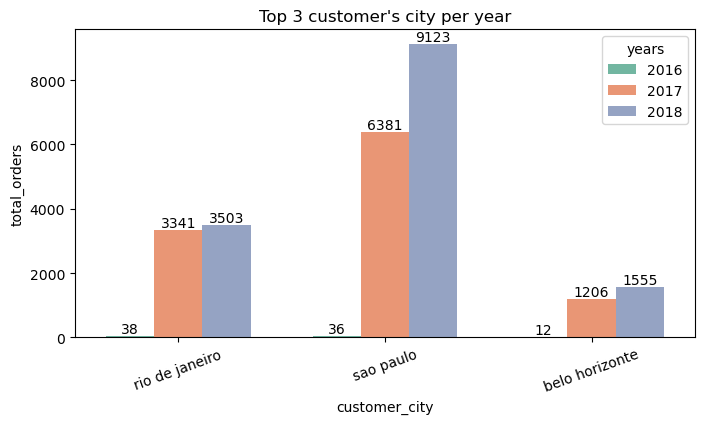

In [14]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x = "customer_city", y = "total_orders", data = df, hue = "years", width=0.7, palette='Set2')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top 3 customer's city per year")
plt.xticks(rotation = 20)
plt.show()

### Identify the top 3 customers who spent the most money in each year.

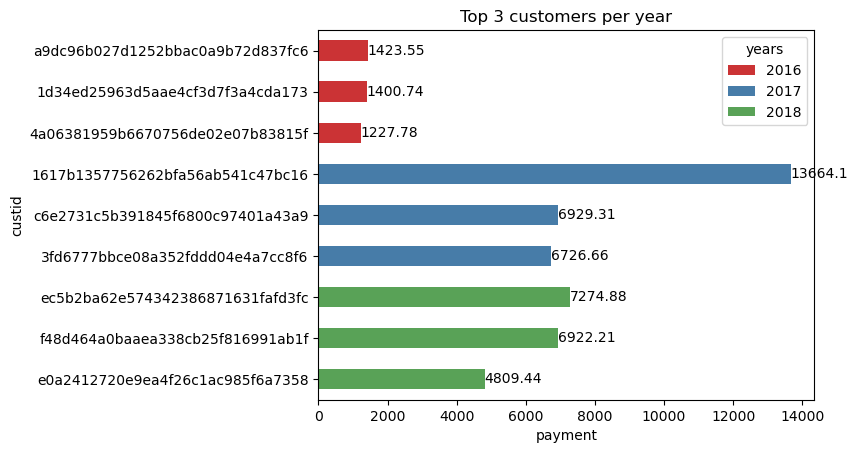

In [15]:
query = """with cust_rank_byyear as
(select EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) order by sum(payments.payment_value) desc) d_rank
from orders 
join payments on payments.order_id = orders.order_id
group by EXTRACT(YEAR FROM order_purchase_timestamp::timestamp), orders.customer_id)

select years, customer_id, payment, d_rank from cust_rank_byyear where d_rank <= 3"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","custid","payment","rank"])
ax = sns.barplot(x = "payment", y = "custid", data = df, hue = "years", width=0.5, palette='Set1', dodge=False, orient='h')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top 3 customers per year")
plt.xticks(rotation = 0)
plt.show()

### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 3 months of their first purchase.

In [16]:
query = """select a.customer_id,count(distinct(a.order_id)) count_orders
from (select customer_id, order_id from orders) a
group by a.customer_id
having count(a.order_id)>1"""

cur.execute(query)
data = cur.fetchall()

data

[]

insight : all customer didn't repurchase, they bought only once.

In [17]:
query = """with first_order as 
(select c.customer_id,
min(o.order_purchase_timestamp) firstorder
from customers c 
join orders o on c.customer_id = o.customer_id
group by c.customer_id),

repurchase as 
(select f.customer_id, count(distinct o.order_id) count_orders
from first_order f 
join orders o on o.customer_id = f.customer_id
and o.order_purchase_timestamp > f.firstorder
and o.order_purchase_timestamp < f.firstorder + interval '3 months'
group by f.customer_id) 

select coalesce(100 * (count(distinct r.customer_id)/count(distinct f.customer_id)),0)
from first_order f 
left join repurchase r on f.customer_id = r.customer_id"""

cur.execute(query)
data = cur.fetchall()

data

[(0,)]

### Calculate the percentage of orders that were paid in installments.

In [18]:
query = """with check_installments as 
(select p.order_id, sum(p.payment_value) total_payments, 
sum(i.price)+sum(round(cast(i.freight_value as numeric),2)) total_invoice
from payments p 
join order_items i on i.order_id=p.order_id
where p.payment_installments>1
group by p.order_id
)

select cast(((count(case when total_payments=total_invoice then 1 else 0 end))/count(order_id)) as float)*100 paid_pct
from check_installments
"""

cur.execute(query)

data = cur.fetchall()

print("The percentage of orders that were paid in installments is", data[0][0])

The percentage of orders that were paid in installments is 100.0


insight : all customers have paid the installments.

### Top 3 rank of seller by total sales per year.

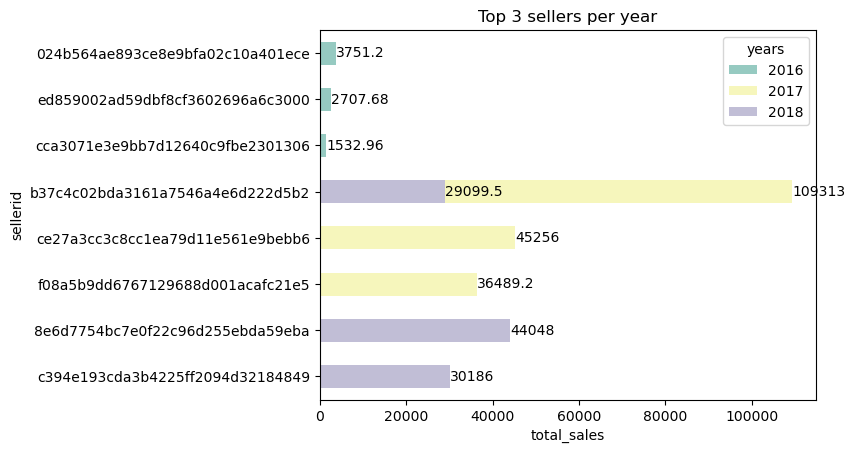

In [19]:
query = """with seller_sales as
(select EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) years, i.seller_id, 
sum(p.payment_value) total_sales,
dense_rank() over(partition by EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) order by sum(p.payment_value) desc) as rn
from order_items i
join payments p on i.order_id = p.order_id
join orders o on o.order_id=i.order_id
group by i.seller_id,o.order_purchase_timestamp)

select years, seller_id, total_sales from seller_sales
where rn<=3
order by years asc,total_sales desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","sellerid","total_sales"])
ax = sns.barplot(x = "total_sales", y = "sellerid", data = df, hue = "years", width=0.5, palette='Set3', dodge=False, orient='h')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Top 3 sellers per year")
#plt.legend(loc = "upper right")
plt.xticks(rotation = 0)
plt.show()